In [118]:
## Basic imports for worling with paths
import os
import sys

## Custom package modules
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)


from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import anal_foc_diff_fields as afi
from misloc_mispol_package.optics import diffraction_int as diffi

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl

# inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)

## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.constants as con
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

import scipy.optimize as opt

eps_b = 1.778
cm_per_nm = 1E-7

pixel_num = 300
boundary_pixel_coords_in_nm = [
    -750,
    750,
    -750,
    750,
    ]
pixel_size = (
    boundary_pixel_coords_in_nm[1] - boundary_pixel_coords_in_nm[0]
    )/(pixel_num)

exp_obs_pts = diffi.observation_points(
    boundary_pixel_coords_in_nm[0]*cm_per_nm, 
    boundary_pixel_coords_in_nm[1]*cm_per_nm, 
    boundary_pixel_coords_in_nm[2]*cm_per_nm, 
    boundary_pixel_coords_in_nm[3]*cm_per_nm, 
    300,) ## cm_per_m

img_extent = [
    boundary_pixel_coords_in_nm[0] - .5*pixel_size,
    boundary_pixel_coords_in_nm[1] + .5*pixel_size,
    boundary_pixel_coords_in_nm[2] - .5*pixel_size,
    boundary_pixel_coords_in_nm[3] + .5*pixel_size,
]

In [119]:
pixel_size

5.0

In [120]:
path_to_data = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'from_Biteen_group',
    'sandwiched_nanodisk',
    'simulations'
    )

Need to be fancy with loading the files because matlab v7.3 files require hdf5, whcih is not included in scipy. 

In [121]:
import h5py

AuND_D80_T30_5_6_19_Spectra = {}
f = h5py.File(
    os.path.join(path_to_data, "AuND_D80_T30_5_6_19_Spectra.mat"), 
    'r')

for key, val in f.items():
    AuND_D80_T30_5_6_19_Spectra[key] = np.array(val)[0]

In [122]:
eps_b = 1.778

In [123]:
print(cp.__file__)


/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/misloc_mispol_package/calc/coupled_dipoles.py


In [124]:

class DiskDipoleProperties(object):
    """ Initialized polarizabilities from disk and molecule from fit paramters
        """


    def __init__(self,
        plas_fit_params=[4.13099032, 6.97497861, 0.84471359, 40. , 84.99522714],
        fluo_fit_params=[2.0, 0.13499613],
        eps_b=eps_b,
        fluo_quench_region_nm=10,
        isolate_mode=None,
        ):

        drive_energy_eV = fluo_fit_params[0]
        
        ## Assign plas fit parameters
        eps_inf=plas_fit_params[0]
        hbar_omega_plasma=plas_fit_params[1]
        hbar_gamma_drude=plas_fit_params[2]
        ax_in_nm = plas_fit_params[3]
        ayz_in_nm = plas_fit_params[4]
    
        ## Assign fluo fit parameters
        ## I don't know if this matters for simulation, and I am not 
        ## sure how the dye molecule is represented in FDTD, so I am 
        ## to stick with these values for R6G for now. 
        fluo_ext_coef=70000 
        ## from https://www.thermofisher.com/order/catalog/product/D6180
        fluo_hw_res = fluo_fit_params[0]
        fluo_nr_hbar_gamma=fluo_fit_params[1]
    
        self.drive_energy_eV = drive_energy_eV
        self.eps_inf = eps_inf
#         print(f"plas_fit_params = {plas_fit_params[1]}")
        self.omega_plasma = hbar_omega_plasma / hbar
        self.gamma_drude = hbar_gamma_drude / hbar
        self.ax_cm = ax_in_nm * cm_per_nm
        self.ayz_cm = ayz_in_nm * cm_per_nm

        self.eps_b = eps_b

        ## hardcoded region around nanoparticle to through out results because
        ## dipole approximation at small proximities
        self.fluo_quench_range = fluo_quench_region_nm

        self.alpha0_diag_dyad = cp.sparse_polarizability_tensor(
            cp.fluorophore_mass(70000, fluo_nr_hbar_gamma/hbar), 
            w_res=fluo_hw_res/hbar, 
            w=drive_energy_eV/hbar, 
            gamma_nr=fluo_nr_hbar_gamma/hbar, 
            a=0, 
            eps_inf=0, 
            eps_b=eps_b,
            )
        
        self.alpha1_diag_dyad = (
            cp.sparse_ret_prolate_spheroid_polarizability_Drude(#eps_inf, w_p, gamma, eps_b, a_x, a_yz,
                w=drive_energy_eV/hbar,
                eps_inf=self.eps_inf, 
                w_p= self.omega_plasma, 
                gamma=self.gamma_drude,
                eps_b=eps_b, 
                a_x=self.ax_cm,
                a_yz=self.ayz_cm,
                isolate_mode=None
                ))
                
class CoupledDipoles(DiskDipoleProperties, fit.FittingTools):

    ## Q: do I need to manually call 'PlottingStuff.__init__'?
    def __init__(self,
        obs_points=None,
#         isolate_mode=None,
        drive_energy_eV=2.44,
        ):
        """
        PlottingStuff.__init__(): Really just calls DipoleProperties.__init__()
            which initializes polarizabilities and maybe some other stuff

        FittingTools.__init__(obs_points): defines obs points or assigns
            default
         """
        
        if obs_points is None: 
            obs_points = exp_obs_pts
            
        DiskDipoleProperties.__init__(self,
#             isolate_mode=isolate_mode,
#             drive_energy_eV=drive_energy_eV,
            )
        fit.FittingTools.__init__(self, obs_points)

    def mb_p_fields(self, dipole_mag_array, dipole_coordinate_array):
        ''' Evaluates analytic form of focused+diffracted dipole fields
            anlong observation grid given

            Args
            ----
                dipole_mag_array: array of dipole moment vecotrs
                    with shape ~(n dipoles, 3 cartesean components)
                dipole_coordinate_array: same shape structure but
                    the locations of the dipoles.

            Returns
            -------
                Fields with shape ~ (3, ?...)



            '''

        p = dipole_mag_array
        # print('Inside mb_p_fields, p= ',p)
        bfx = dipole_coordinate_array

        v_rel_obs_x_pts = (self.obs_points[1].ravel()[:,None] - bfx.T[0]).T
        v_rel_obs_y_pts = (self.obs_points[2].ravel()[:,None] - bfx.T[1]).T

        px_fields = np.asarray(
            afi.E_field(
                0,
                v_rel_obs_x_pts,
                v_rel_obs_y_pts,
                (self.drive_energy_eV/hbar)*np.sqrt(self.eps_b)/c
                )
            )
        py_fields = np.asarray(
            afi.E_field(
                np.pi/2,
                v_rel_obs_x_pts,
                v_rel_obs_y_pts,
                (self.drive_energy_eV/hbar)*np.sqrt(self.eps_b)/c
                )
            )
        # This is not true, but does not matter as long as no dipoles have
        # z components.
        pz_fields = np.zeros(py_fields.shape)

        ## returns [Ex, Ey, Ez] for dipoles oriented along cart units

        Ex = (
            p[:,0,None]*px_fields[0]
            +
            p[:,1,None]*py_fields[0]
            +
            p[:,2,None]*pz_fields[0]
            )
        Ey = (
            p[:,0,None]*px_fields[1]
            +
            p[:,1,None]*py_fields[1]
            +
            p[:,2,None]*pz_fields[1]
            )
        Ez = (
            p[:,0,None]*px_fields[2]
            +
            p[:,1,None]*py_fields[2]
            +
            p[:,2,None]*pz_fields[2]
            )

        return np.array([Ex,Ey,Ez])


    def dipole_fields(
        self, 
        locations, 
        mol_angle=0, 
        plas_angle=np.pi/2, 
        plas_centroid=[0, 0]
        ):
        """ Calculate image fields of coupled plasmon and molecule
            dipole.

            Args
            ----


            Returns
            -------
            [mol_E, plas_E, p0_unc_E, p0, p1]
            """
        d = locations*cm_per_nm
        plas_loc = np.asarray(plas_centroid)*cm_per_nm
        p0, p1 = cp.dipole_mags_gened(
            mol_angle,
            plas_angle,
            d_col=d,
            E_d_angle=None,
            alpha0_diag=self.alpha0_diag_dyad,
            alpha1_diag=self.alpha1_diag_dyad,
            )
        mol_E = self.mb_p_fields(
            dipole_mag_array=p0,
            dipole_coordinate_array=d+plas_loc,
            )
        
        plas_E = self.mb_p_fields(
            dipole_mag_array=p1,
            dipole_coordinate_array=plas_loc,
            )

        # p0_unc, = cp.uncoupled_p0(mol_angle=0, d_col=d[0,None], E_d_angle=None)
        p0_unc, = cp.uncoupled_p0(
            mol_angle,
            E_d_angle=None,
            drive_hbar_w=self.drive_energy_eV,
            )
    #     print('p0.shape = ',p0.shape)
    #     print('p1.shape = ',p1.shape)
    #     print('p0_unc.shape = ',p0_unc.shape)
    #     p0_unc_E = self.mb_p_fields(dipole_mag_array=p0_unc[None,:], dipole_coordinate_array=np.zeros(d[0][None,:].shape))
        if type(mol_angle)==np.ndarray and mol_angle.shape[0]>1:
            p0_unc_E = self.mb_p_fields(
                dipole_mag_array=p0_unc,
                dipole_coordinate_array=d
                )
        elif (type(mol_angle) == int or
              type(mol_angle) == float or
              type(mol_angle) == np.float64 or
              (type(mol_angle) == np.ndarray and mol_angle.shape[0]==1)
              ):
            p0_unc_E = self.mb_p_fields(
                dipole_mag_array=p0_unc[None,:],
                dipole_coordinate_array=d,
                )
#         print(type(mol_angle))
        return [mol_E, plas_E, p0_unc_E, p0, p1]



#### Test model by generating images

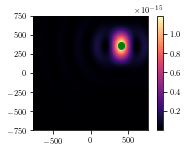

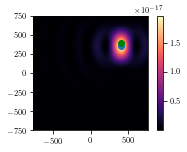

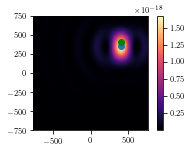

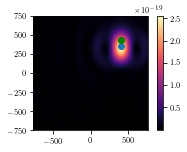

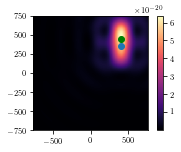

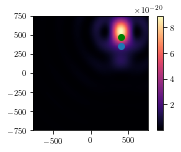

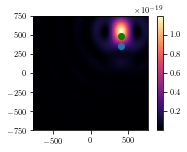

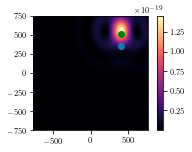

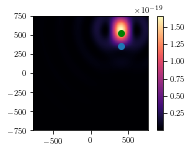

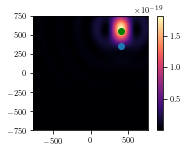

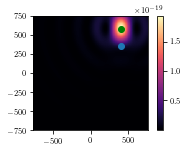

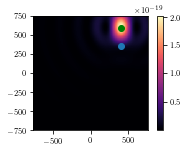

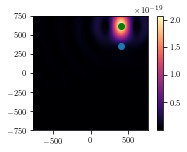

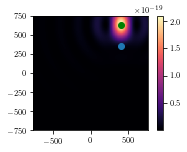

In [125]:
cp_inst=CoupledDipoles()

for i in np.arange(20, 300, 20):
    field_output = cp_inst.dipole_fields(
            np.array([[0,i, 0]]), 
            mol_angle=np.pi/2, 
            plas_angle=np.pi/2, 
            plas_centroid=np.array([[400, 350, 0]])
            )
    a_coup_image = cp_inst.image_from_E(field_output[0]+field_output[1])


    
    plt.figure()
    ax=plt.axes()
    
    img = ax.imshow( 
        a_coup_image.reshape(pixel_num, pixel_num).T, origin='lower',
        extent=img_extent)

    ax.scatter(400, 350)
    
    ax.scatter(0+400, i+350, c='green')
    plt.colorbar(img)
    plt.show()

Ok, model is ready to go. Next thing to do is load the images to fit. 

In [126]:
import h5py

AuND_D80_T30_5_6_19_Spectra = {}
f = h5py.File(
    os.path.join(path_to_data, "AuND_D80_T30_5_6_19_Spectra.mat"), 
    'r')

for key, val in f.items():
    AuND_D80_T30_5_6_19_Spectra[key] = np.array(val)[0]
    
def load_mat_var_dict(path):
    
    ## Initialize dict
    mat_var_dict = {}
    ## Load file
    f = h5py.File(
        path, 
        'r')
    ## Iterate through hdf5 file and get variables
    for key, val in f.items():
        mat_var_dict[key] = np.array(val)
        
    return mat_var_dict

AuND_D80T30_140_90_10_30_19_ff = load_mat_var_dict(
    os.path.join(path_to_data, "AuND_D80T30_140_90_10_30_19_ff.mat"))

In [127]:
AuND_D80T30_140_90_10_30_19_ff.keys()

dict_keys(['Exff', 'Eyff', 'Ezff', 'NA', 'dipole_power', 'f', 'index', 'res', 'source_power', 'x_dip', 'x_image', 'y_dip', 'y_image', 'z0', 'z_dip'])

In [165]:
## Build crossection from simulated data and parameters
def field_at_max_hw(spec_dict, field_dict):
    sigma_scat_data = (
        spec_dict['transscat'] 
        * spec_dict['source_power']
        / spec_dict['source_intensity']
        )

    ## Load energies to find energy of max intensity
    hw = hbar * 2 * np.pi * spec_dict['f']

    max_idx = np.argmax(np.abs(sigma_scat_data))
    max_hw = hw[max_idx]
    # max_idx = 0

    ## Build field vector at spectral maximum energy.     
    ## For some reason the dimensions are inverted...
    field_at_peak = [
        field_dict['Exff'][max_idx, :,:],
        field_dict['Eyff'][max_idx, :,:],
        field_dict['Ezff'][max_idx, :,:],]
    
    return field_at_peak, max_hw

field_at_2eV, max_hw = field_at_max_hw(
    AuND_D80_T30_5_6_19_Spectra, AuND_D80T30_140_90_10_30_19_ff)
    
# sigma_scat_data = (
#     AuND_D80_T30_5_6_19_Spectra['transscat'] 
#     * AuND_D80_T30_5_6_19_Spectra['source_power']
#     / AuND_D80_T30_5_6_19_Spectra['source_intensity']
#     )

# ## Load energies to find energy of max intensity
# hw = hbar * 2 * np.pi * AuND_D80_T30_5_6_19_Spectra['f']

# max_idx = np.argmax(np.abs(sigma_scat_data))
# max_hw = hw[max_idx]
# # max_idx = 0

# ## Build field vector at spectral maximum energy.     
# ## For some reason the dimensions are inverted...
# field_at_2eV = [
#     AuND_D80T30_140_90_10_30_19_ff['Exff'][max_idx, :,:],
#     AuND_D80T30_140_90_10_30_19_ff['Eyff'][max_idx, :,:],
#     AuND_D80T30_140_90_10_30_19_ff['Ezff'][max_idx, :,:],]

In [129]:
max_hw

1.9521471837226567

In [166]:
def matlab_tuple_to_complex(tuple_field_vec):
    ## Restructure tuples into complex field
    E = np.zeros((3,)+tuple_field_vec[0].shape, dtype=complex)

    for i in range(3):
        for row_idx, row in enumerate(tuple_field_vec[i]):
            for col_idx, elem in enumerate(row):
                E[i, row_idx, col_idx] = elem[0] + 1j*elem[1]
                
    return E

E = matlab_tuple_to_complex(field_at_2eV)

E_sqrd = np.abs(E[0])**2. + np.abs(E[1])**2. + np.abs(E[2])**2.

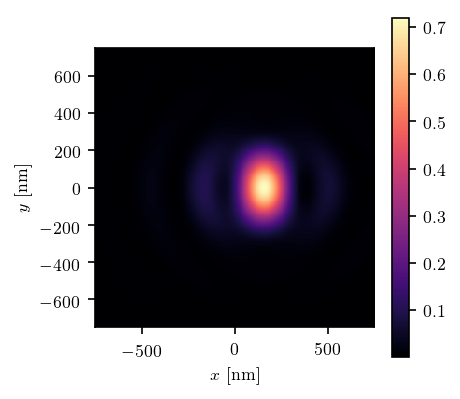

In [167]:
def img_extent(field_dict):
    
    ## Define extent in nanometers.
    extent_nm = np.array([
        field_dict['x_image'].min(),
        field_dict['x_image'].max(),
        field_dict['y_image'].min(),
        field_dict['y_image'].max(),])*(1e9) #nm/m

    return extent_nm
    
    
E_sqrd = np.abs(E[0])**2. + np.abs(E[1])**2. + np.abs(E[2])**2.

## Define extent in nanometers.
extent = img_extent(AuND_D80T30_140_90_10_30_19_ff) 

## Test plot image. 
plt.figure(dpi=150, figsize=(3,3))
plt.imshow(np.abs(E_sqrd), origin='lower', extent=extent)
plt.xlabel('$x$ [nm]')
plt.ylabel('$y$ [nm]')
plt.colorbar()

Combine functions to load image from matlab field file.

In [169]:
def img_from_matlab(img_file_path, spec_file_path=None):
    """ Loads img from Curly's matlab variable dicts.
        Returns: E_sqrd, max_hw, extent_nm
        """
    spec_dict = {}
    if spec_file_path is None:
        spec_file_path = os.path.join(path_to_data, "AuND_D80_T30_5_6_19_Spectra.mat")
    ## Load spectrum with hdf5
    f = h5py.File(
        spec_file_path, 
        'r')
    ## Place matlab variables into dict. 
    for key, val in f.items():
        spec_dict[key] = np.array(val)[0]
    
    ## Do the same with the field dict
    field_dict = load_mat_var_dict(img_file_path)
    
    ## Get field at spectral peak as well as energy of max spectral 
    ## response.
    field_at_peak, max_hw = field_at_max_hw(spec_dict, field_dict)
    
    ## Build complex field array from tuples loaded by hdf5
    E = matlab_tuple_to_complex(field_at_peak)
    
    ## Construct image
    E_sqrd = np.abs(E[0])**2. + np.abs(E[1])**2. + np.abs(E[2])**2.
    
    ## get image extent in nm
    extent_nm = img_extent(field_dict)
    
    return E_sqrd, max_hw, extent_nm
    
    
def position_of_max_img_intensity():
    
    

#### On to the model

In [170]:
def image_from_params(
    params, 
    plas_loc,
    drive_hw,
    resolution=None,
    ):
    """ 
        Args
        ----
        
        params = [
            d=[x, y, z], : mol location relative to plasmon
            phi, : mole angle
            ]
    
        """
    dx = params[0]
    dy = params[1]
    phi = params[2]
    
    if resolution is None:
        obs_pts = None
    else:
        obs_pts = diffi.observation_points(
            0, 48*20*m_per_nm, 0, 48*20*m_per_nm, resolution)
        
    cp_inst=CoupledDipoles(
        obs_points=obs_pts, 
        drive_energy_eV=drive_hw)
    field_output = cp_inst.dipole_fields(
            np.array([[dx, dy, 0]]), 
            mol_angle=phi, 
            plas_angle=0, 
            plas_centroid=np.array([plas_loc])
            )
    raveled_image = cp_inst.image_from_E(field_output[0]+field_output[1])
    
    return raveled_image
    
    
def fit_image_w_coupled_model(
    image,                           
    plas_loc,         
    img_hw,
    ini_guess_params=None,):
    """
        """
#     min_max_fit_pixles = [190, 210]
    data = image#.reshape((300,300))[
#         min_max_fit_pixles[0]:min_max_fit_pixles[1], 
#         min_max_fit_pixles[0]:min_max_fit_pixles[1]]
    
    model = lambda params: image_from_params(
        params, 
        plas_loc,
        drive_hw=img_hw).ravel()#.reshape((300,300))[
#         min_max_fit_pixles[0]:min_max_fit_pixles[1], 
#         min_max_fit_pixles[0]:min_max_fit_pixles[1]]
    
#     cost_func = 
    if ini_guess_params is None: 
        ini_guess_params = (100, 100, 0)
    
    fit_result = opt.least_squares(
        lambda fit_params: (
            data.ravel()/data.max() 
            - 
            model(fit_params).ravel()/ model(fit_params).max()
            ),
        ini_guess_params,
        x_scale=[1E2,1E2,1],
#         loss='soft_l1'
        )
    
    return fit_result

### Try the fit

In [85]:
from time import time

In [140]:
the_plas_loc = [0,0,0]

start_time = time()

resuuuult = fit_image_w_coupled_model(
    E_sqrd.ravel(), 
    the_plas_loc, 
    img_hw=max_hw)

fit_time = time() - start_time

KeyboardInterrupt: 

In [248]:
np.argmax(E_sqrd)

44881

In [141]:
print(f'Took {fit_time/60:.2f} minutes to fit')

Took 1.64 minutes to fit


Text(15.863735546820951, 0.5, '$y$ [nm]')

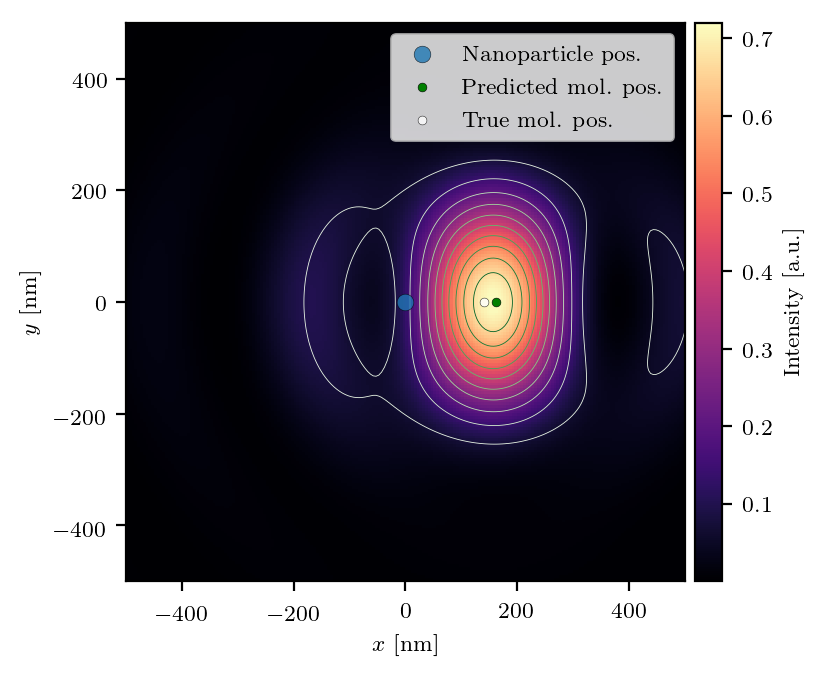

In [142]:
##### print(f'processing figure {i}')
    
fig, axs = plt.subplots(
    ncols=1,
    dpi=200,
    figsize=(4,4)
    )

axs = [axs]


img1 = axs[0].imshow(
    E_sqrd,
    origin='lower',
    extent=extent
    )
#         if ax_idx is 0:
#             axs[ax_idx].text(
#                 0, 1, f'Image idx: {i}', 
#                 style='italic',
#                 bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1},
#                 transform=axs[0].transAxes,
#                 verticalalignment='bottom'
#                 )
## Add colorbar
divider = make_axes_locatable(axs[0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img1, cax=cax1, label='Intensity [a.u.]')

plt.tight_layout(h_pad=1)


# axs[0].contour(
#     np.linspace(0,48*(21-1), 201),
#     np.linspace(0,48*(21-1), 201),
#     RealFittingTools.twoD_Gaussian(
#         None,
#         (high_res_obs_pts[1]/m_per_nm, high_res_obs_pts[2]/m_per_nm),
#         *gauss_fit_to_bgsub_2692['x']
#         ).reshape(high_res_obs_pts[1].shape),
#     cmap='Wistia',
#     linewidths=0.5,
#     levels=2
#     )


# axs[0].contour(
#     np.linspace(0,48*(21-1), 201),
#     np.linspace(0,48*(21-1), 201),
#     RealFittingTools.twoD_Gaussian(
#         None,
#         (high_res_obs_pts[1]/m_per_nm, high_res_obs_pts[2]/m_per_nm),
#         *gauss_fit_to_bg_2692['x']
#         ).reshape(high_res_obs_pts[1].shape),
#     cmap='winter_r',
#     linewidths=0.5,
#     levels=2
#     )

axs[0].contour(
    np.linspace(-750, 750 ,300),
    np.linspace(-750, 750 ,300),
    (image_from_params(
        resuuuult['x'], 
        the_plas_loc,
        drive_hw=max_hw,
#         resolution=201
        )).reshape(300,300),
    cmap='Greens',
    linewidths=0.3,
    levels=10,
#     label='model img.'
    )

## Mark plasmon position
axs[0].scatter(
    the_plas_loc[1], 
    the_plas_loc[0], 
    zorder=5,
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='Nanoparticle pos.'
    )

## Mark predicted molecule postions
axs[0].scatter(
    resuuuult['x'][1]+the_plas_loc[1], 
    resuuuult['x'][0]+the_plas_loc[0], 
    zorder=5,
    s = 10,
    c='green',
    edgecolor='k',
    linewidth=.2,
    label='Predicted mol. pos.'
    )

## Mark true molecule postion
axs[0].scatter(
    140+the_plas_loc[1], 
    0+the_plas_loc[0], 
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )

axs[0].legend(fontsize=8)
axs[0].set_xlim([-500,500])
axs[0].set_ylim([-500,500])

axs[0].set_xlabel('$x$ [nm]')
axs[0].set_ylabel('$y$ [nm]')
# plt.legend()
# axs[0].scatter(
#     gauss_fit_to_bgsub_2692['x'][2], 
#     gauss_fit_to_bgsub_2692['x'][1], 
#     zorder=5,
#     s = 10,
#     c='orange',
#     alpha=.8,
#     edgecolor='k',
#     linewidth=.2
#     )

In [104]:
AuND_D80T30_140_90_fit_params = resuuuult['x']
AuND_D80T30_140_90_fit_params

array([-1.85029683e-02,  1.62483967e+02, -4.49935498e-04])

Cool, let's fit the other images. 

In [171]:
## Load img
AuND_D80T30_140_90_10_30_19_ff_img = img_from_matlab(
    img_file_path=os.path.join(path_to_data,'AuND_D80T30_140_90_10_30_19_ff.mat')
    )

In [174]:
## Load img
AuND_D80T30_140_0_10_30_19_ff_img = img_from_matlab(
    img_file_path=os.path.join(path_to_data,'AuND_D80T30_140_0_10_30_19_ff.mat')
    )

## Run fit with timer
##~~~~~~~~~~~~~~~~~~~
start_time = time()

AuND_D80T30_140_0_10_30_19_ff_fit = fit_image_w_coupled_model(
    AuND_D80T30_140_0_10_30_19_ff_img[0].ravel(), 
    the_plas_loc,
    img_hw=AuND_D80T30_140_0_10_30_19_ff_img[1])

AuND_D80T30_140_0_10_30_19_ff_fit_time = time() - start_time
print(f'AuND_D80T30_140_0_10_30_19_ff fit in {AuND_D80T30_140_0_10_30_19_ff_fit_time/60} min')

AuND_D80T30_140_0_10_30_19_ff fit in 3.2269691030184426 min


In [175]:
AuND_D80T30_140_0_10_30_19_ff_fit

 active_mask: array([0., 0., 0.])
        cost: 29.901115780053367
         fun: array([-2.91036663e-03, -2.54832765e-03, -2.19602048e-03, ...,
       -8.01116700e-07, -2.37228364e-04, -5.10150298e-04])
        grad: array([6.99465503e-03, 1.37741006e-05, 9.17230591e-02])
         jac: array([[-3.01711261e-05,  6.07320484e-05,  2.15005990e-03],
       [-2.76048668e-05,  5.80148794e-05,  2.62354846e-03],
       [-2.48756260e-05,  5.53642880e-05,  3.00240611e-03],
       ...,
       [ 3.46368615e-05,  3.80393539e-05,  3.70172898e-04],
       [ 3.84416926e-05,  3.88401147e-05, -3.67256721e-04],
       [ 4.13295638e-05,  3.98316531e-05, -1.17486811e-03]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 27
        njev: 20
  optimality: 0.09172305914526291
      status: 2
     success: True
           x: array([ 3.61340491e-03,  1.26627294e+02, -1.57054835e+00])

In [176]:
## Load img
AuND_D80T30_90_0_10_30_19_ff_img = img_from_matlab(
    img_file_path=os.path.join(path_to_data,'AuND_D80T30_90_0_10_30_19_ff.mat')
    )

## Run fit with timer
##~~~~~~~~~~~~~~~~~~~
start_time = time()

AuND_D80T30_90_0_10_30_19_ff_fit = fit_image_w_coupled_model(
    AuND_D80T30_90_0_10_30_19_ff_img[0].ravel(), 
    the_plas_loc,
    img_hw=AuND_D80T30_90_0_10_30_19_ff_img[1])

AuND_D80T30_90_0_10_30_19_ff_fit_time = time() - start_time
print(f'AuND_D80T30_90_0_10_30_19_ff fit in {AuND_D80T30_90_0_10_30_19_ff_fit_time/60} min')

AuND_D80T30_90_0_10_30_19_ff fit in 2.2154335021972655 min


In [177]:
AuND_D80T30_90_0_10_30_19_ff_fit

 active_mask: array([0., 0., 0.])
        cost: 71.44742974733259
         fun: array([-0.00265661, -0.00290566, -0.00316711, ..., -0.00462463,
       -0.0048203 , -0.00500482])
        grad: array([ 1.19870634e-06,  1.05092800e-04, -1.87766897e-04])
         jac: array([[ 1.16137937e-04,  6.34807090e-06,  3.06318107e-05],
       [ 1.25335127e-04,  8.39758841e-06,  7.61797128e-05],
       [ 1.33589520e-04,  1.00064652e-05,  1.47143466e-04],
       ...,
       [ 1.56369363e-04, -1.07518166e-05,  3.03836586e-03],
       [ 1.50606392e-04, -1.65880295e-05,  3.42947035e-03],
       [ 1.43556546e-04, -2.27782767e-05,  3.82129679e-03]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 18
        njev: 18
  optimality: 0.00018776689660526813
      status: 2
     success: True
           x: array([5.09965678e+01, 6.86114640e+01, 6.81186869e-02])

In [178]:
## Load img
AuND_D80T30_90_90_10_30_19_ff_img = img_from_matlab(
    img_file_path=os.path.join(path_to_data,'AuND_D80T30_90_90_10_30_19_ff.mat')
    )

## Run fit with timer
##~~~~~~~~~~~~~~~~~~~
start_time = time()

AuND_D80T30_90_90_10_30_19_ff_fit = fit_image_w_coupled_model(
    AuND_D80T30_90_90_10_30_19_ff_img[0].ravel(), 
    the_plas_loc,
    img_hw=AuND_D80T30_90_90_10_30_19_ff_img[1])

AuND_D80T30_90_90_10_30_19_ff_fit_time = time() - start_time
print(f'AuND_D80T30_90_90_10_30_19_ff fit in {AuND_D80T30_90_90_10_30_19_ff_fit_time/60} min')

AuND_D80T30_90_90_10_30_19_ff fit in 1.711202903588613 min


In [179]:
AuND_D80T30_90_90_10_30_19_ff_fit

 active_mask: array([0., 0., 0.])
        cost: 5.513760752445441
         fun: array([-0.00015279, -0.00021099, -0.00029219, ..., -0.00265535,
       -0.00286496, -0.0030707 ])
        grad: array([-0.00073979,  0.0005625 ,  0.2682724 ])
         jac: array([[-1.42448916e-05,  2.36808394e-05, -1.92592153e-03],
       [-1.30828776e-05,  2.86716490e-05, -2.11392478e-03],
       [-1.19679171e-05,  3.33774873e-05, -2.25582176e-03],
       ...,
       [-1.01425976e-05,  4.75000636e-05, -5.60504297e-04],
       [-1.15137955e-05,  4.78065935e-05, -1.98107708e-04],
       [-1.29908440e-05,  4.77585400e-05,  1.94987573e-04]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 20
        njev: 11
  optimality: 0.2682724048611469
      status: 2
     success: True
           x: array([9.43141289e-02, 1.14626868e+02, 6.62794114e-04])

In [180]:
## Load img
AuND_D80T30_60_0_10_30_19_ff_img = img_from_matlab(
    img_file_path=os.path.join(path_to_data,'AuND_D80T30_60_0_10_30_19_ff.mat')
    )

## Run fit with timer
##~~~~~~~~~~~~~~~~~~~
start_time = time()

AuND_D80T30_60_0_10_30_19_ff_fit = fit_image_w_coupled_model(
    AuND_D80T30_60_0_10_30_19_ff_img[0].ravel(), 
    the_plas_loc,
    img_hw=AuND_D80T30_60_0_10_30_19_ff_img[1])

AuND_D80T30_60_0_10_30_19_ff_fit_time = time() - start_time
print(f'AuND_D80T30_60_0_10_30_19_ff fit in {AuND_D80T30_60_0_10_30_19_ff_fit_time/60} min')

AuND_D80T30_60_0_10_30_19_ff fit in 1.7923828999201457 min


In [181]:
AuND_D80T30_60_0_10_30_19_ff_fit

 active_mask: array([0., 0., 0.])
        cost: 15.997579120131318
         fun: array([-0.00296407, -0.00323901, -0.00351588, ..., -0.00476819,
       -0.00480153, -0.00481811])
        grad: array([-2.07357577e-07,  1.38207081e-05, -8.21241123e-05])
         jac: array([[ 0.00017626, -0.0001112 ,  0.00465147],
       [ 0.00018293, -0.00012051,  0.00501391],
       [ 0.00018846, -0.00012992,  0.00537473],
       ...,
       [ 0.00018078, -0.00021183,  0.00893968],
       [ 0.00017237, -0.00021998,  0.00919836],
       [ 0.0001629 , -0.00022743,  0.00941955]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 12
        njev: 12
  optimality: 8.212411230346106e-05
      status: 2
     success: True
           x: array([ 4.40815185e+01,  5.26185136e+01, -2.89996587e-02])

In [182]:
## Load img
AuND_D80T30_60_90_10_30_19_ff_img = img_from_matlab(
    img_file_path=os.path.join(path_to_data,'AuND_D80T30_60_90_10_30_19_ff.mat')
    )

## Run fit with timer
##~~~~~~~~~~~~~~~~~~~
start_time = time()

AuND_D80T30_60_90_10_30_19_ff_fit = fit_image_w_coupled_model(
    AuND_D80T30_60_90_10_30_19_ff_img[0].ravel(), 
    the_plas_loc,
    img_hw=AuND_D80T30_60_90_10_30_19_ff_img[1])

AuND_D80T30_60_90_10_30_19_ff_fit_time = time() - start_time
print(f'AuND_D80T30_60_90_10_30_19_ff fit in {AuND_D80T30_60_90_10_30_19_ff_fit_time/60} min')

AuND_D80T30_60_90_10_30_19_ff fit in 3.28551211754481 min


In [183]:
AuND_D80T30_60_90_10_30_19_ff_fit

 active_mask: array([0., 0., 0.])
        cost: 20.178482775418313
         fun: array([-0.00184403, -0.00205827, -0.0022746 , ..., -0.00485762,
       -0.00496025, -0.00504281])
        grad: array([ 2.26272546e-03, -2.09430865e-05,  1.18492501e+00])
         jac: array([[-1.47857179e-04,  7.72793774e-05, -8.95986456e-03],
       [-1.56702823e-04,  7.77412352e-05, -9.29414353e-03],
       [-1.65145902e-04,  7.73704246e-05, -9.57399548e-03],
       ...,
       [-2.14421714e-04,  3.93509447e-05, -8.28004495e-03],
       [-2.15926033e-04,  3.38145802e-05, -7.95062887e-03],
       [-2.16499961e-04,  2.78372188e-05, -7.57410907e-03]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 29
        njev: 21
  optimality: 1.184925014378975
      status: 2
     success: True
           x: array([-5.42718983e-02,  7.66433925e+01,  2.48845529e-04])

In [184]:
## Load img
AuND_D80T30_55_0_10_30_19_ff_img = img_from_matlab(
    img_file_path=os.path.join(path_to_data,'AuND_D80T30_55_0_10_30_19_ff.mat')
    )

## Run fit with timer
##~~~~~~~~~~~~~~~~~~~
start_time = time()

AuND_D80T30_55_0_10_30_19_ff_fit = fit_image_w_coupled_model(
    AuND_D80T30_55_0_10_30_19_ff_img[0].ravel(), 
    the_plas_loc,
    img_hw=AuND_D80T30_55_0_10_30_19_ff_img[1])

AuND_D80T30_55_0_10_30_19_ff_fit_time = time() - start_time
print(f'AuND_D80T30_55_0_10_30_19_ff fit in {AuND_D80T30_55_0_10_30_19_ff_fit_time/60} min')

AuND_D80T30_55_0_10_30_19_ff fit in 1.5079678853352865 min


In [185]:
AuND_D80T30_55_0_10_30_19_ff_fit

 active_mask: array([0., 0., 0.])
        cost: 13.906570084692984
         fun: array([-0.0031162 , -0.00338584, -0.00365453, ..., -0.00479095,
       -0.00478461, -0.00476081])
        grad: array([2.68770319e-06, 1.16152175e-05, 1.28700726e-04])
         jac: array([[ 0.00019081, -0.00013222,  0.00539128],
       [ 0.00019735, -0.00014271,  0.00578102],
       [ 0.00020275, -0.00015314,  0.00616358],
       ...,
       [ 0.00019459, -0.00023384,  0.00952504],
       [ 0.00018647, -0.00024067,  0.0097281 ],
       [ 0.00017732, -0.00024663,  0.00988958]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 12
        njev: 12
  optimality: 0.00012870072556125933
      status: 2
     success: True
           x: array([ 4.13906220e+01,  5.11748753e+01, -7.70903911e-03])

In [186]:
## Load img
AuND_D80T30_55_90_10_30_19_ff_img = img_from_matlab(
    img_file_path=os.path.join(path_to_data,'AuND_D80T30_55_90_10_30_19_ff.mat')
    )

## Run fit with timer
##~~~~~~~~~~~~~~~~~~~
start_time = time()

AuND_D80T30_55_90_10_30_19_ff_fit = fit_image_w_coupled_model(
    AuND_D80T30_55_90_10_30_19_ff_img[0].ravel(), 
    the_plas_loc,
    img_hw=AuND_D80T30_55_90_10_30_19_ff_img[1])

AuND_D80T30_55_90_10_30_19_ff_fit_time = time() - start_time
print(f'AuND_D80T30_55_90_10_30_19_ff fit in {AuND_D80T30_55_90_10_30_19_ff_fit_time/60} min')

AuND_D80T30_55_90_10_30_19_ff_fit

AuND_D80T30_55_90_10_30_19_ff fit in 3.0992387692133585 min


 active_mask: array([0., 0., 0.])
        cost: 26.27310399615387
         fun: array([-0.00272818, -0.00294501, -0.0031549 , ..., -0.00524134,
       -0.00527559, -0.00528661])
        grad: array([ 2.14060446e-04,  4.85461848e-05, -9.37619829e-01])
         jac: array([[-2.65686685e-04,  7.70525039e-05, -1.28614098e-02],
       [-2.79138563e-04,  7.51534854e-05, -1.33206875e-02],
       [-2.91628006e-04,  7.24998254e-05, -1.37161345e-02],
       ...,
       [-3.44578759e-04,  2.35668995e-05, -1.30250808e-02],
       [-3.43163090e-04,  1.70851682e-05, -1.26817247e-02],
       [-3.40202183e-04,  1.03102098e-05, -1.22758648e-02]])
     message: 'Both `ftol` and `xtol` termination conditions are satisfied.'
        nfev: 31
        njev: 21
  optimality: 0.937619828738967
      status: 4
     success: True
           x: array([ 8.94574684e-02,  6.60176784e+01, -7.74000318e-04])

In [187]:
## Load img
AuND_D80T30_50_0_10_30_19_ff_img = img_from_matlab(
    img_file_path=os.path.join(path_to_data,'AuND_D80T30_50_0_10_30_19_ff.mat')
    )

## Run fit with timer
##~~~~~~~~~~~~~~~~~~~
start_time = time()

AuND_D80T30_50_0_10_30_19_ff_fit = fit_image_w_coupled_model(
    AuND_D80T30_50_0_10_30_19_ff_img[0].ravel(), 
    the_plas_loc,
    img_hw=AuND_D80T30_50_0_10_30_19_ff_img[1])

AuND_D80T30_50_0_10_30_19_ff_fit_time = time() - start_time
print(f'AuND_D80T30_50_0_10_30_19_ff fit in {AuND_D80T30_50_0_10_30_19_ff_fit_time/60} min')

AuND_D80T30_50_0_10_30_19_ff_fit

AuND_D80T30_50_0_10_30_19_ff fit in 1.5132885694503784 min


 active_mask: array([0., 0., 0.])
        cost: 13.479787315322277
         fun: array([-0.0032814 , -0.00354038, -0.0037954 , ..., -0.00478775,
       -0.00473824, -0.0046709 ])
        grad: array([7.94977804e-06, 9.38171907e-06, 5.94005496e-04])
         jac: array([[ 0.00020865, -0.00015087,  0.00604143],
       [ 0.0002153 , -0.0001619 ,  0.00644085],
       [ 0.00022081, -0.00017269,  0.00682712],
       ...,
       [ 0.0002139 , -0.00024546,  0.00981101],
       [ 0.00020618, -0.00025038,  0.00994502],
       [ 0.00019741, -0.00025431,  0.0100349 ]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 13
        njev: 13
  optimality: 0.0005940054955697605
      status: 2
     success: True
           x: array([3.80449651e+01, 4.99016708e+01, 3.53446563e-02])

In [188]:
## Load img
AuND_D80T30_5_90_10_30_19_ff_img = img_from_matlab(
    img_file_path=os.path.join(path_to_data,'AuND_D80T30_5_90_10_30_19_ff.mat')
    )

## Run fit with timer
##~~~~~~~~~~~~~~~~~~~
start_time = time()

AuND_D80T30_5_90_10_30_19_ff_fit = fit_image_w_coupled_model(
    AuND_D80T30_5_90_10_30_19_ff_img[0].ravel(), 
    the_plas_loc,
    img_hw=AuND_D80T30_5_90_10_30_19_ff_img[1])

AuND_D80T30_5_90_10_30_19_ff_fit_time = time() - start_time
print(f'AuND_D80T30_5_90_10_30_19_ff fit in {AuND_D80T30_5_90_10_30_19_ff_fit_time/60} min')

AuND_D80T30_5_90_10_30_19_ff_fit

AuND_D80T30_50_90_10_30_19_ff fit in 3.2742135167121886 min


 active_mask: array([0., 0., 0.])
        cost: 28.008951958916604
         fun: array([-0.00530529, -0.00533946, -0.00535268, ..., -0.005103  ,
       -0.00495097, -0.004784  ])
        grad: array([ 6.80175123e-05,  8.06317717e-05, -3.22126580e-03])
         jac: array([[ 1.14405881e-04,  1.71464838e-04, -9.69401252e-03],
       [ 1.21628729e-04,  1.77135064e-04, -9.82974435e-03],
       [ 1.27576572e-04,  1.81904915e-04, -9.91288031e-03],
       ...,
       [ 9.66528199e-05,  1.78550167e-04, -7.29052199e-03],
       [ 8.67978464e-05,  1.73871934e-04, -6.98196341e-03],
       [ 7.60657067e-05,  1.68328206e-04, -6.64939772e-03]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 23
        njev: 23
  optimality: 0.003221265804882023
      status: 2
     success: True
           x: array([ 74.91910127, -26.41427454,  -0.70075506])

Build function for plotting 

In [279]:
def plot_fit_results(img, img_hw, extent, fit, mol_pos):

    fig, axs = plt.subplots(
        ncols=1,
        dpi=200,
        figsize=(4,4)
        )

    axs = [axs]

    img1 = axs[0].imshow(
        img,
        origin='lower',
        extent=extent
        )

    ## Add colorbar
    divider = make_axes_locatable(axs[0])
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax1, label='Intensity [a.u.]')

    plt.tight_layout(h_pad=1)

    axs[0].contour(
        np.linspace(-750, 750, 300),
        np.linspace(-750, 750, 300),
        (image_from_params(
            fit['x'], 
            the_plas_loc,
            drive_hw=img_hw,
    #         resolution=201
            )).reshape(300,300),
        cmap='Greens',
        linewidths=0.3,
        levels=10,
    #     label='model img.'
        )

    ## Mark plasmon position
#     axs[0].scatter(
#         the_plas_loc[1], 
#         the_plas_loc[0], 
#         zorder=5,
#         alpha=.8,
#         edgecolor='k',
#         linewidth=.2,
#         label='Nanodisk pos.'
#         )
    disk_patch = mpl.patches.Circle(
        (the_plas_loc[1], the_plas_loc[0]),
        40,
        # facecolor='Gold',
        facecolor=(241/255, 223/255, 182/255),
        edgecolor='Black',
        linewidth=.2,
        )
    axs[0].add_patch(disk_patch)

    ## Mark predicted molecule postions
    axs[0].scatter(
        fit['x'][1]+the_plas_loc[1], 
        fit['x'][0]+the_plas_loc[0], 
        zorder=5,
        s = 10,
        c='green',
        edgecolor='k',
        linewidth=.2,
        label=f"Predicted mol.: ({fit['x'][1]:.1f}, {fit['x'][0]:.1f}) nm, @ {fit['x'][2]*180/np.pi+90:.0f} deg."
        )

    ## Mark true molecule postion
    axs[0].scatter(
        mol_pos[0]+the_plas_loc[1], 
        mol_pos[1]+the_plas_loc[0], 
        zorder=5,
        s = 10,
        c='w',
        alpha=.8,
        edgecolor='k',
        linewidth=.2,
        label=f'True mol.: ({mol_pos[0]:d}, {mol_pos[1]:d}) nm, @ {mol_pos[2]:.0f} deg.')
    
    axs[0].legend(fontsize=7)
    axs[0].set_xlim([-500,500])
    axs[0].set_ylim([-500,500])

    axs[0].set_xlabel('$x$ [nm]')
    axs[0].set_ylabel('$y$ [nm]')
    
    axs[0].set_title('Model fit to Simulated Image (with $\mathrm{SiO}_2$ and Cr)')
    
    return axs

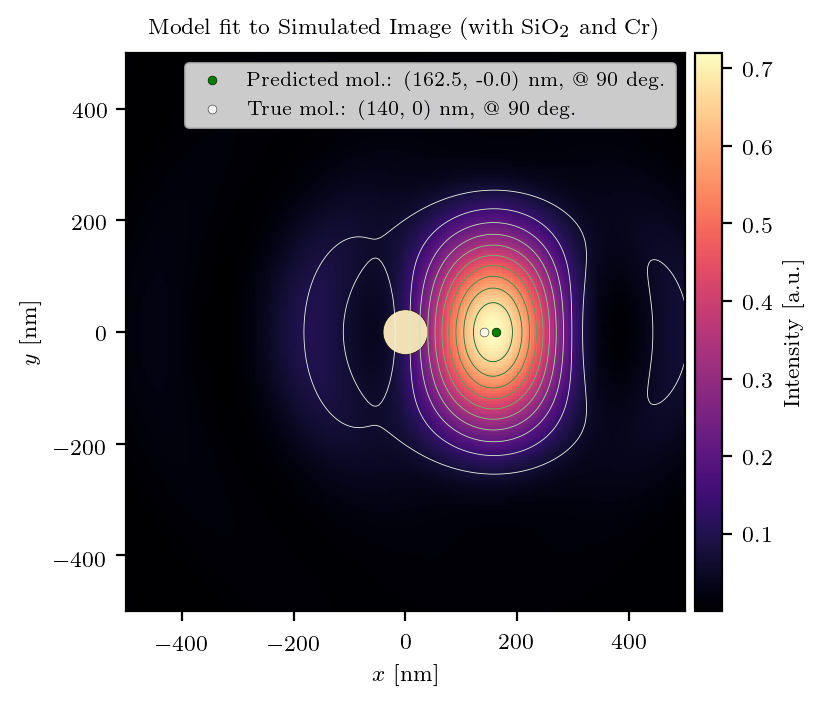

In [291]:
plot_fit_results(
    E_sqrd, max_hw, extent,
    resuuuult, 
    [140, 0, 90]
    )

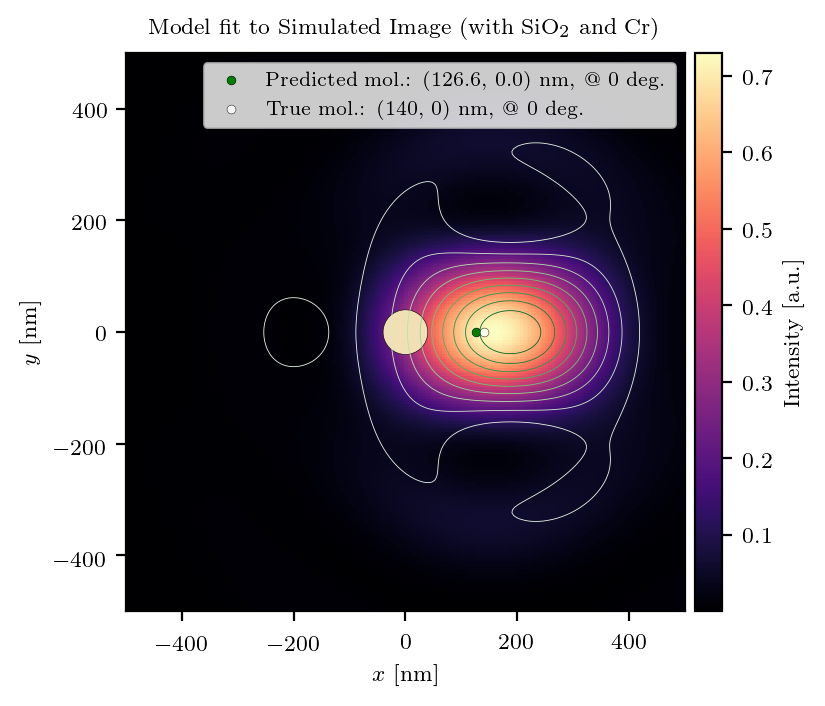

In [280]:
plot_fit_results(
    *AuND_D80T30_140_0_10_30_19_ff_img, 
    AuND_D80T30_140_0_10_30_19_ff_fit, 
    [140, 0, 0]
    )

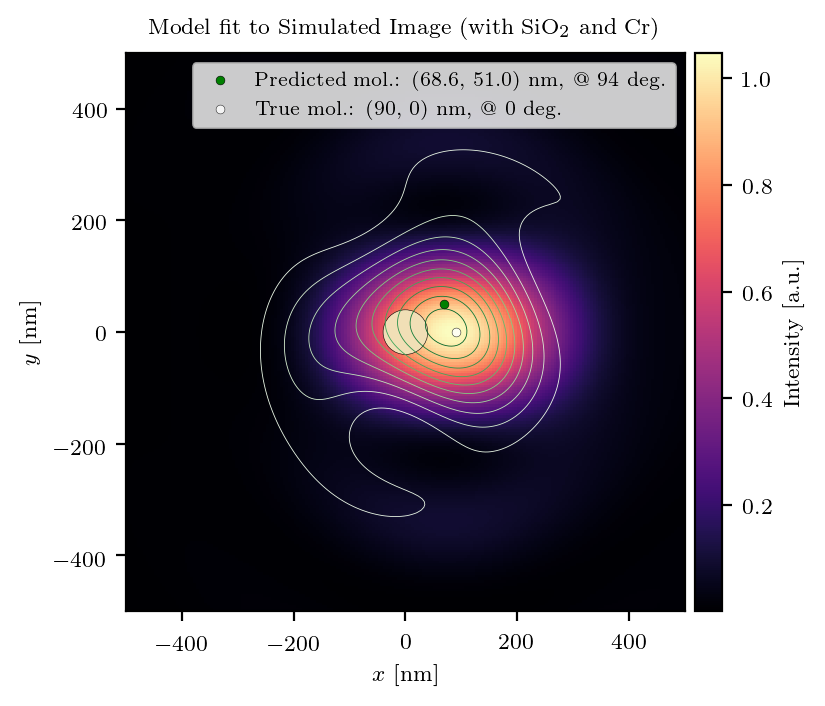

In [281]:
plot_fit_results(
    *AuND_D80T30_90_0_10_30_19_ff_img, 
    AuND_D80T30_90_0_10_30_19_ff_fit, 
    [90,0, 0]
)

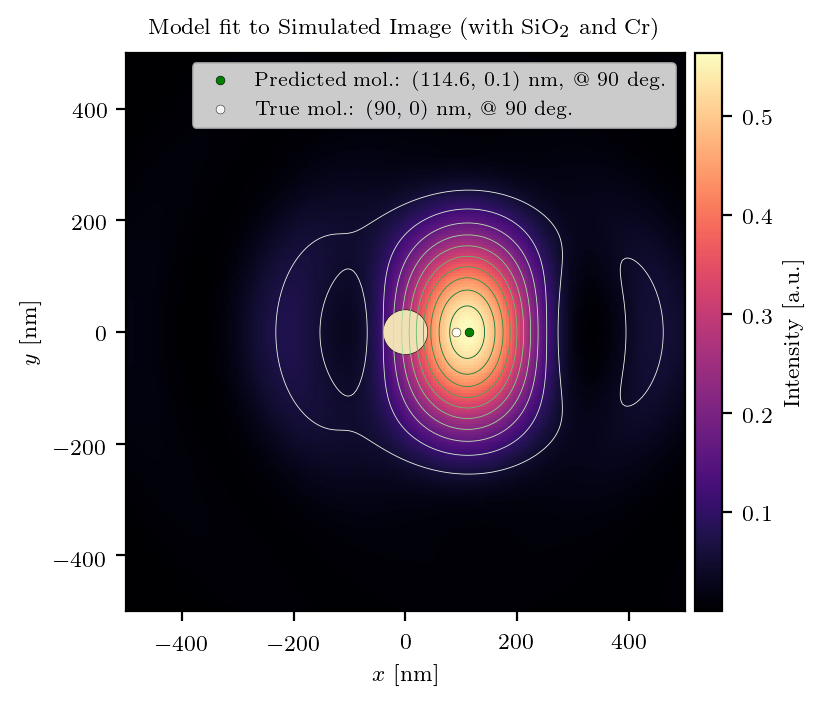

In [282]:
plot_fit_results(
    *AuND_D80T30_90_90_10_30_19_ff_img, 
    AuND_D80T30_90_90_10_30_19_ff_fit, 
    [90,0, 90]
)

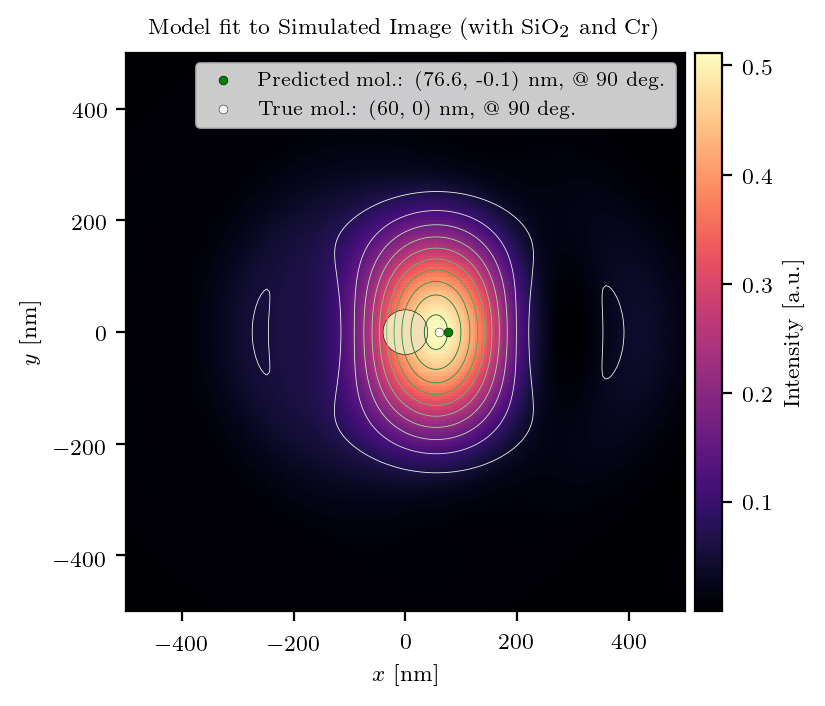

In [283]:
plot_fit_results(
    *AuND_D80T30_60_90_10_30_19_ff_img, 
    AuND_D80T30_60_90_10_30_19_ff_fit, 
    [60,0, 90])

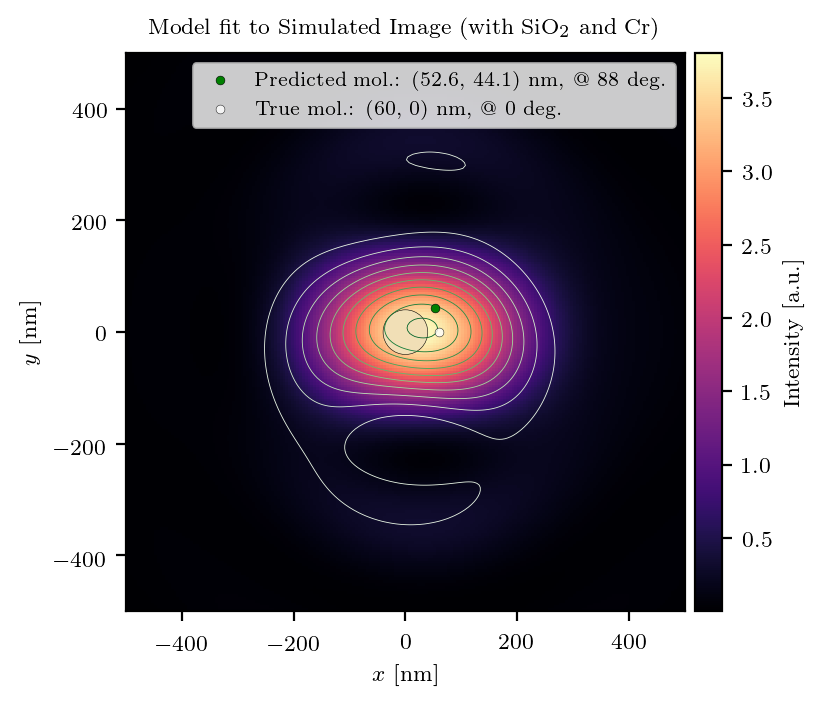

In [285]:
plot_fit_results(
    *AuND_D80T30_60_0_10_30_19_ff_img, 
    AuND_D80T30_60_0_10_30_19_ff_fit, 
    [60,0,0])

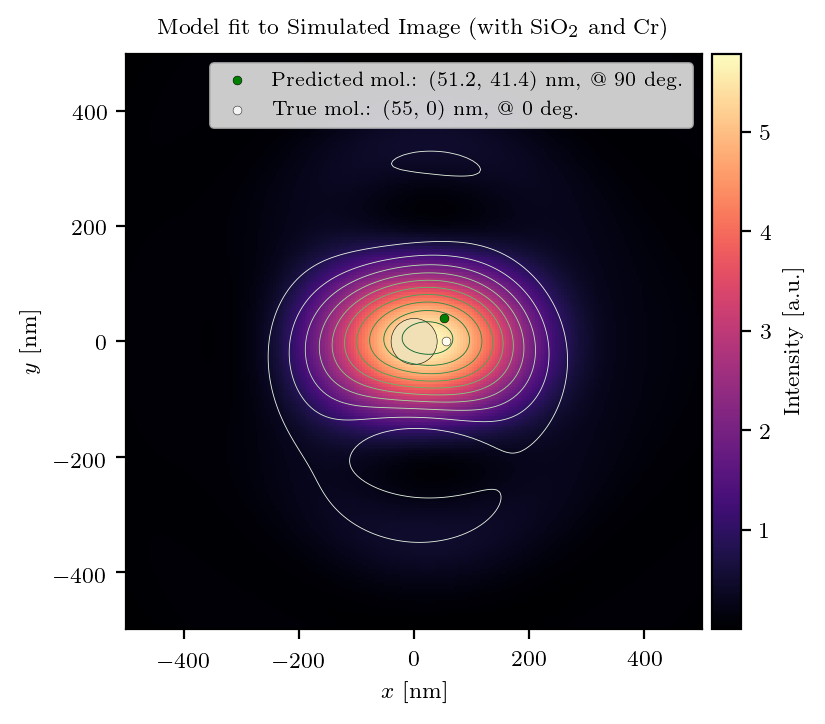

In [286]:
plot_fit_results(
    *AuND_D80T30_55_0_10_30_19_ff_img, 
    AuND_D80T30_55_0_10_30_19_ff_fit, 
    [55,0,0])

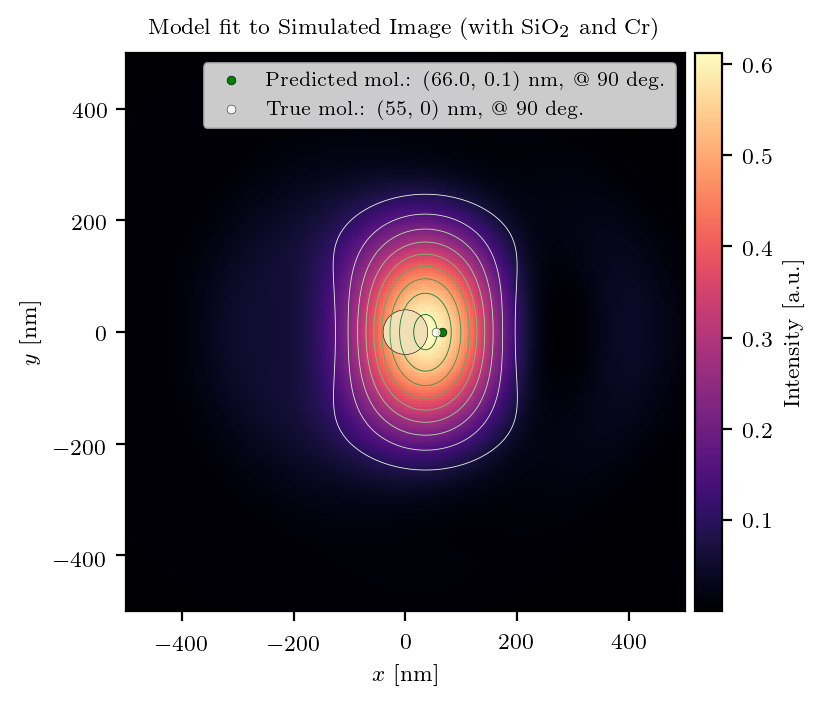

In [287]:
plot_fit_results(
    *AuND_D80T30_55_90_10_30_19_ff_img, 
    AuND_D80T30_55_90_10_30_19_ff_fit, 
    [55,0,90])

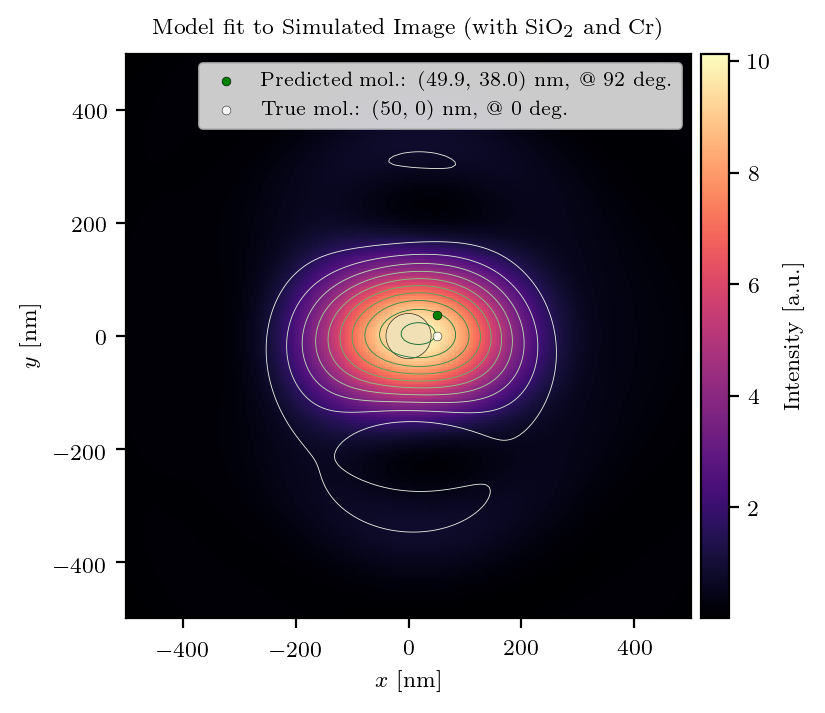

In [288]:
plot_fit_results(
    *AuND_D80T30_50_0_10_30_19_ff_img, 
    AuND_D80T30_50_0_10_30_19_ff_fit, 
    [50,0,0])

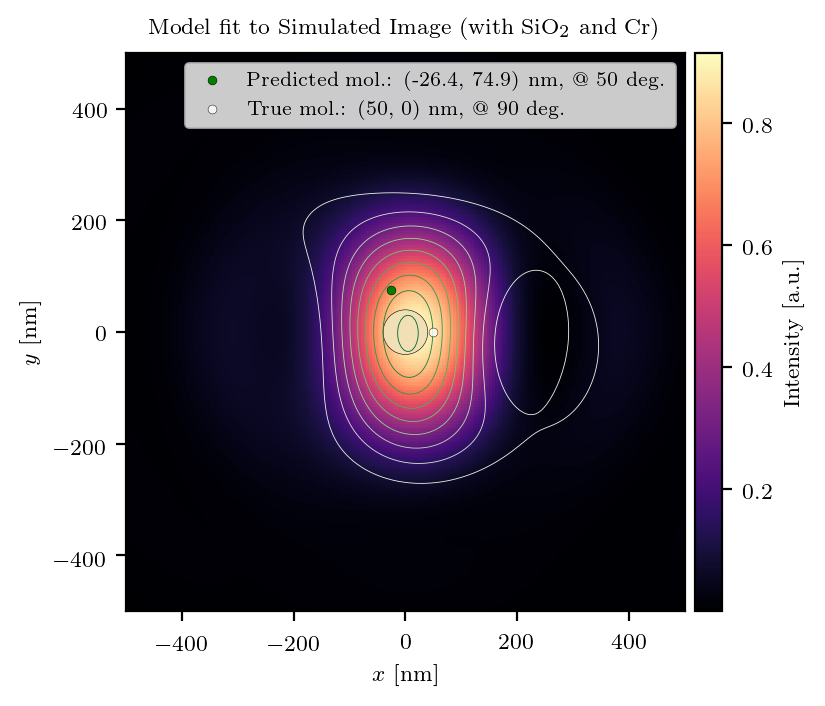

In [289]:
plot_fit_results(
    *AuND_D80T30_50_90_10_30_19_ff_img, 
    AuND_D80T30_50_90_10_30_19_ff_fit, 
    [50,0,90])

What I should do is pcik the initial guess by the max. 

In [ ]:
## Fit with max initial guess
##~~~~~~~~~~~~~~~~~~~
start_time = time()

AuND_D80T30_140_0_10_30_19_ff_fit = fit_image_w_coupled_model(
    AuND_D80T30_140_0_10_30_19_ff_img[0].ravel(), 
    the_plas_loc,
    img_hw=AuND_D80T30_140_0_10_30_19_ff_img[1])

AuND_D80T30_140_0_10_30_19_ff_fit_time = time() - start_time
print(f'AuND_D80T30_140_0_10_30_19_ff fit in {AuND_D80T30_140_0_10_30_19_ff_fit_time/60} min')